
# Bayesian Optimization
# Optimizing the SGD Learning Rate when Training a Neural Network

### Roger Garrida
### Akhil Lohia
### Daniel Velasquez

# Introduction 


Training a neural network can be a difficult task. In particular, due to the large number of hyperparameters that need to be tunned, e.g. number of layers, number of hidden units, batch size among other. In this project, we focus on one particular hyperparameter that influence directly the success of the learning procedure: The stochastic gradient descent **learning rate **. We use bayesian optimization to tune the learning rate and compare the results with a grid search.

In [1]:
#Required libraries
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import math as mat
import scipy
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
from tqdm import tqdm #add progress bar to for loops
import math

## Gaussian Process

In [2]:
def gaussian_kernel(x1,x2,noise,length): #Generate the kernel (cov) of the Gaussian Process
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    kernel = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            kernel[i,j] = noise**2*mat.exp(-0.5*((x1[i]-x2[j])/length)**2)
    return kernel


In [3]:
def LLH_GP(x,y,m,noise,length, sf = 0): #Compute the likelihood of the data (add sf if consider noise)
    ker = gaussian_kernel(x,x, noise, length)
    ker = ker+np.diag([sf]*len(x))
    return 1/2*(mat.log(np.linalg.det(ker))+np.dot(np.dot(np.transpose(y-m),
                                                       np.linalg.inv(ker)),(y-m)))


In [4]:
def opt_hyparams(x,y): #Find the hyperparameters that optimize LLH without noise
    ini = np.array([0,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], params[1], params[2]),
                            ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = 0.001
    return m, noise, length, sf  

In [5]:
def opt_hyparams_noise(x,y): #Find the hyperparameters that optimize LLH with noise
    ini = np.array([0,1,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], 
                                                  params[1], params[2], params[3]),ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = abs(params[3])
    return m, noise, length, sf

In [6]:
#Generates the mean and covariance of the posterior distribution in the given grid (xn) 
#from data (x,y) and the optimized parameters (mean->m, noise, length, noise in y -> sf)
def gp_posterior(x, y, xn, m, noise, length, sf = 0): 
    kxx = gaussian_kernel(x, x, noise = noise, length = length)
    kxxn = gaussian_kernel(x, xn, noise = noise, length = length)
    kxnx = gaussian_kernel(xn, x, noise = noise, length = length)
    kxnxn = gaussian_kernel(xn, xn, noise = noise, length = length)
    core = np.linalg.inv(kxx + np.diag([sf]*len(x)))
    En = np.dot(np.dot(kxnx, core), y)
    covn = kxnxn - np.dot(np.dot(kxnx, core), kxxn)  
    
    return En, covn

In [7]:
def data_posterior(x, E, cov):
    data = pd.DataFrame({'x': x})
    data['Mean'] = E
    data['StdDev'] = np.sqrt(np.diag(cov))
    #Generate the 5 samples as multivariate normals with 0 mean and covariance sigma
    for i in range(5):
        data['y'+str(i)] = np.random.multivariate_normal(E, cov)
    return data


# Neural Network Architecture and Dataset

Our goal is to perform classification on the MNIST dataset. To do so, we build a neural network with one hidden layer and a fixed number of hidden units. We divide the dataset in training and test sample. We define a function that trains the network as a function of the learning rate and returns a measure of accuracy estimated using the test sample. The accuracy corresponds the number of correctly classified observations divided by the total number of observations within the test sample. 

In [8]:
#MNIST dataset:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, validation_size=0)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
#placeholder:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

##Variables:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    #initial = tf.ones(shape)/10
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def neural_network(input, h_dim):
    W0 = weight_variable([784, h_dim])
    b0 = bias_variable([h_dim])
    h = tf.nn.relu(tf.matmul(input, W0) + b0)

    W = weight_variable([h_dim, 10])
    b = bias_variable([10])

    y = tf.nn.softmax(tf.matmul(h, W) + b)
    return y

#Network training:
def nn_train(learning_rate, h_dim, minibatch = 100):
    y = neural_network(x, h_dim)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    #train_step = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    #n_samples = len(mnist.train.images)
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    tf.global_variables_initializer().run()
    for i in range(10000+1):
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0): #Training accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0): #Test accuracy update
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))

        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})


    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))


# Network training with variable learning rate

def nn_train_var(min_lr, max_lr, h_dim, minibatch = 100):
    
    # variable learning rate
    lr = tf.placeholder(tf.float32)
    
    y = neural_network(x, h_dim)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    #cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))*minibatch
    
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # training step, the learning rate is a placeholder
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)
    #train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)
    
    tf.global_variables_initializer().run()
    
    for i in range(10000+1):
        # learning rate decay
        decay_speed = 2000.0
        learning_rate = min_lr + (max_lr - min_lr) * math.exp(-i/decay_speed)
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        
        if (i%20 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: batch_xs, y_: batch_ys})
            print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        
        if (i%100 == 0):
            a, c = sess.run([accuracy, cross_entropy], {x: mnist.test.images, y_: mnist.test.labels})
            print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, lr:learning_rate})

    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

# Adquisition Function

We start with a gaussian prior on the hyperparameters. We define an adquisicion function that allows us to select a new learning rate to test. In particular we use *Expected Improvement*. With each new value, we train the network and use the output (i.e. the classification accuracy) to update the prior density. Notice that in this case, we want maximize the accuracy. 

In [10]:
#Adquisition function

def acquisition_fun(x, y, xn, mean_vector, sigma_vector):
    x_best = x[np.argmax(y)]
    y_best = np.max(y)
    ind_cand = np.array([not any(abs(xi-x)<=0.00001) for xi in xn]) #Indicator of candidates
    gamma = (mean_vector[ind_cand] - y_best)/sigma_vector[ind_cand]
    af = (mean_vector[ind_cand] - y_best)* norm.cdf(gamma) + sigma_vector[ind_cand]*norm.pdf(gamma)

    x_next = xn[ind_cand][np.argmax(af)]
    return x_next


# Algorithm


Initially, we assume we only observe 2 potential learning rates and their corresponding accuracy. We implement an algorithm that, given some prior on the learning rate, at each iteration the acquisition function selects a new candidate learning rate, then trains the network and estimates the posterior density. The plots below shows inital observations, the mean and 1 standard deviation around the mean. 

When implementing the algorith we can assume that the observed accuracies contains noise or not. Given that in practice the classification accuracy of the neural network is not a deterministic function of the learning rate, we assume the observe values contain some noise. 

  0%|          | 0/2 [00:00<?, ?it/s]

0: accuracy:0.07 loss: 2.31048 (lr:0.1)
0: ********* epoch 1 ********* test accuracy:0.0742 test loss: 2.31189
20: accuracy:0.15 loss: 2.30191 (lr:0.1)
40: accuracy:0.26 loss: 2.27976 (lr:0.1)
60: accuracy:0.28 loss: 2.26954 (lr:0.1)
80: accuracy:0.3 loss: 2.16096 (lr:0.1)
100: accuracy:0.32 loss: 2.13484 (lr:0.1)
100: ********* epoch 1 ********* test accuracy:0.3156 test loss: 2.15654
120: accuracy:0.4 loss: 2.10834 (lr:0.1)
140: accuracy:0.51 loss: 2.06892 (lr:0.1)
160: accuracy:0.55 loss: 2.01661 (lr:0.1)
180: accuracy:0.58 loss: 1.9898 (lr:0.1)
200: accuracy:0.56 loss: 1.99048 (lr:0.1)
200: ********* epoch 1 ********* test accuracy:0.5904 test loss: 1.95428
220: accuracy:0.62 loss: 1.93321 (lr:0.1)
240: accuracy:0.69 loss: 1.85624 (lr:0.1)
260: accuracy:0.72 loss: 1.84226 (lr:0.1)
280: accuracy:0.76 loss: 1.77519 (lr:0.1)
300: accuracy:0.74 loss: 1.79533 (lr:0.1)
300: ********* epoch 1 ********* test accuracy:0.7044 test loss: 1.82272
320: accuracy:0.62 loss: 1.87094 (lr:0.1)
340: 

2900: ********* epoch 5 ********* test accuracy:0.8385 test loss: 1.6311
2920: accuracy:0.79 loss: 1.68488 (lr:0.1)
2940: accuracy:0.83 loss: 1.64225 (lr:0.1)
2960: accuracy:0.87 loss: 1.60485 (lr:0.1)
2980: accuracy:0.78 loss: 1.68133 (lr:0.1)
3000: accuracy:0.88 loss: 1.59112 (lr:0.1)
3000: ********* epoch 6 ********* test accuracy:0.8384 test loss: 1.6306
3020: accuracy:0.77 loss: 1.69307 (lr:0.1)
3040: accuracy:0.85 loss: 1.62494 (lr:0.1)
3060: accuracy:0.89 loss: 1.57257 (lr:0.1)
3080: accuracy:0.82 loss: 1.6402 (lr:0.1)
3100: accuracy:0.83 loss: 1.64439 (lr:0.1)
3100: ********* epoch 6 ********* test accuracy:0.839 test loss: 1.62979
3120: accuracy:0.87 loss: 1.61065 (lr:0.1)
3140: accuracy:0.85 loss: 1.62278 (lr:0.1)
3160: accuracy:0.86 loss: 1.61127 (lr:0.1)
3180: accuracy:0.83 loss: 1.66041 (lr:0.1)
3200: accuracy:0.88 loss: 1.5859 (lr:0.1)
3200: ********* epoch 6 ********* test accuracy:0.8401 test loss: 1.6293
3220: accuracy:0.83 loss: 1.64063 (lr:0.1)
3240: accuracy:0.86 lo

5780: accuracy:0.83 loss: 1.63642 (lr:0.1)
5800: accuracy:0.81 loss: 1.6547 (lr:0.1)
5800: ********* epoch 10 ********* test accuracy:0.8479 test loss: 1.61819
5820: accuracy:0.8 loss: 1.65859 (lr:0.1)
5840: accuracy:0.8 loss: 1.65328 (lr:0.1)
5860: accuracy:0.86 loss: 1.61417 (lr:0.1)
5880: accuracy:0.86 loss: 1.60774 (lr:0.1)
5900: accuracy:0.77 loss: 1.68884 (lr:0.1)
5900: ********* epoch 10 ********* test accuracy:0.8489 test loss: 1.61745
5920: accuracy:0.85 loss: 1.62072 (lr:0.1)
5940: accuracy:0.83 loss: 1.61628 (lr:0.1)
5960: accuracy:0.81 loss: 1.65486 (lr:0.1)
5980: accuracy:0.88 loss: 1.57422 (lr:0.1)
6000: accuracy:0.86 loss: 1.60443 (lr:0.1)
6000: ********* epoch 11 ********* test accuracy:0.8489 test loss: 1.61732
6020: accuracy:0.86 loss: 1.5945 (lr:0.1)
6040: accuracy:0.82 loss: 1.63735 (lr:0.1)
6060: accuracy:0.82 loss: 1.64595 (lr:0.1)
6080: accuracy:0.83 loss: 1.62738 (lr:0.1)
6100: accuracy:0.82 loss: 1.64234 (lr:0.1)
6100: ********* epoch 11 ********* test accuracy

8700: accuracy:0.82 loss: 1.65339 (lr:0.1)
8700: ********* epoch 15 ********* test accuracy:0.854 test loss: 1.61078
8720: accuracy:0.9 loss: 1.56724 (lr:0.1)
8740: accuracy:0.85 loss: 1.62144 (lr:0.1)
8760: accuracy:0.81 loss: 1.65183 (lr:0.1)
8780: accuracy:0.91 loss: 1.55472 (lr:0.1)
8800: accuracy:0.87 loss: 1.59935 (lr:0.1)
8800: ********* epoch 15 ********* test accuracy:0.8536 test loss: 1.61081
8820: accuracy:0.85 loss: 1.6162 (lr:0.1)
8840: accuracy:0.83 loss: 1.63476 (lr:0.1)
8860: accuracy:0.85 loss: 1.61358 (lr:0.1)
8880: accuracy:0.84 loss: 1.61955 (lr:0.1)
8900: accuracy:0.85 loss: 1.61509 (lr:0.1)
8900: ********* epoch 15 ********* test accuracy:0.8552 test loss: 1.6101
8920: accuracy:0.89 loss: 1.58323 (lr:0.1)
8940: accuracy:0.84 loss: 1.61237 (lr:0.1)
8960: accuracy:0.91 loss: 1.56357 (lr:0.1)
8980: accuracy:0.8 loss: 1.65379 (lr:0.1)
9000: accuracy:0.89 loss: 1.57475 (lr:0.1)
9000: ********* epoch 16 ********* test accuracy:0.8544 test loss: 1.60991
9020: accuracy:0.

 50%|█████     | 1/2 [00:27<00:27, 27.62s/it]

10000: accuracy:0.91 loss: 1.56432 (lr:0.1)
10000: ********* epoch 17 ********* test accuracy:0.8563 test loss: 1.60805
0: accuracy:0.09 loss: 2.31029 (lr:8.0)
0: ********* epoch 1 ********* test accuracy:0.0882 test loss: 2.31303
20: accuracy:0.54 loss: 1.917 (lr:8.0)
40: accuracy:0.72 loss: 1.7228 (lr:8.0)
60: accuracy:0.64 loss: 1.81264 (lr:8.0)
80: accuracy:0.86 loss: 1.60035 (lr:8.0)
100: accuracy:0.89 loss: 1.58409 (lr:8.0)
100: ********* epoch 1 ********* test accuracy:0.8727 test loss: 1.59142
120: accuracy:0.87 loss: 1.597 (lr:8.0)
140: accuracy:0.88 loss: 1.58075 (lr:8.0)
160: accuracy:0.85 loss: 1.62107 (lr:8.0)
180: accuracy:0.83 loss: 1.6366 (lr:8.0)
200: accuracy:0.84 loss: 1.6239 (lr:8.0)
200: ********* epoch 1 ********* test accuracy:0.8685 test loss: 1.59294
220: accuracy:0.9 loss: 1.55695 (lr:8.0)
240: accuracy:0.83 loss: 1.61964 (lr:8.0)
260: accuracy:0.9 loss: 1.55555 (lr:8.0)
280: accuracy:0.85 loss: 1.60432 (lr:8.0)
300: accuracy:0.9 loss: 1.56097 (lr:8.0)
300: **

2840: accuracy:0.96 loss: 1.50066 (lr:8.0)
2860: accuracy:0.88 loss: 1.58186 (lr:8.0)
2880: accuracy:0.94 loss: 1.51996 (lr:8.0)
2900: accuracy:0.93 loss: 1.53599 (lr:8.0)
2900: ********* epoch 5 ********* test accuracy:0.9535 test loss: 1.50756
2920: accuracy:0.98 loss: 1.48153 (lr:8.0)
2940: accuracy:0.92 loss: 1.54108 (lr:8.0)
2960: accuracy:0.95 loss: 1.5111 (lr:8.0)
2980: accuracy:0.94 loss: 1.52154 (lr:8.0)
3000: accuracy:0.96 loss: 1.49918 (lr:8.0)
3000: ********* epoch 6 ********* test accuracy:0.953 test loss: 1.50796
3020: accuracy:0.92 loss: 1.54122 (lr:8.0)
3040: accuracy:0.96 loss: 1.49727 (lr:8.0)
3060: accuracy:0.93 loss: 1.53143 (lr:8.0)
3080: accuracy:0.93 loss: 1.52743 (lr:8.0)
3100: accuracy:0.97 loss: 1.49135 (lr:8.0)
3100: ********* epoch 6 ********* test accuracy:0.9537 test loss: 1.5068
3120: accuracy:0.96 loss: 1.50117 (lr:8.0)
3140: accuracy:0.94 loss: 1.51825 (lr:8.0)
3160: accuracy:0.96 loss: 1.49952 (lr:8.0)
3180: accuracy:0.95 loss: 1.51121 (lr:8.0)
3200: a

5760: accuracy:0.94 loss: 1.5238 (lr:8.0)
5780: accuracy:0.98 loss: 1.48115 (lr:8.0)
5800: accuracy:0.95 loss: 1.51115 (lr:8.0)
5800: ********* epoch 10 ********* test accuracy:0.938 test loss: 1.52303
5820: accuracy:0.95 loss: 1.5112 (lr:8.0)
5840: accuracy:0.96 loss: 1.50115 (lr:8.0)
5860: accuracy:0.93 loss: 1.53115 (lr:8.0)
5880: accuracy:0.98 loss: 1.48115 (lr:8.0)
5900: accuracy:0.96 loss: 1.50187 (lr:8.0)
5900: ********* epoch 10 ********* test accuracy:0.9541 test loss: 1.50686
5920: accuracy:0.95 loss: 1.51115 (lr:8.0)
5940: accuracy:0.97 loss: 1.48882 (lr:8.0)
5960: accuracy:0.95 loss: 1.51109 (lr:8.0)
5980: accuracy:0.97 loss: 1.49157 (lr:8.0)
6000: accuracy:0.94 loss: 1.52115 (lr:8.0)
6000: ********* epoch 11 ********* test accuracy:0.9488 test loss: 1.51243
6020: accuracy:0.94 loss: 1.52116 (lr:8.0)
6040: accuracy:0.93 loss: 1.53118 (lr:8.0)
6060: accuracy:0.96 loss: 1.50113 (lr:8.0)
6080: accuracy:0.99 loss: 1.47122 (lr:8.0)
6100: accuracy:0.97 loss: 1.49681 (lr:8.0)
6100

8600: ********* epoch 15 ********* test accuracy:0.955 test loss: 1.50625
8620: accuracy:1.0 loss: 1.46115 (lr:8.0)
8640: accuracy:0.97 loss: 1.49245 (lr:8.0)
8660: accuracy:0.98 loss: 1.48115 (lr:8.0)
8680: accuracy:0.93 loss: 1.53114 (lr:8.0)
8700: accuracy:0.95 loss: 1.51115 (lr:8.0)
8700: ********* epoch 15 ********* test accuracy:0.9536 test loss: 1.50751
8720: accuracy:0.97 loss: 1.49122 (lr:8.0)
8740: accuracy:0.95 loss: 1.51204 (lr:8.0)
8760: accuracy:0.98 loss: 1.48127 (lr:8.0)
8780: accuracy:0.94 loss: 1.52114 (lr:8.0)
8800: accuracy:0.99 loss: 1.47116 (lr:8.0)
8800: ********* epoch 15 ********* test accuracy:0.9574 test loss: 1.50325
8820: accuracy:0.97 loss: 1.49115 (lr:8.0)
8840: accuracy:0.93 loss: 1.53047 (lr:8.0)
8860: accuracy:0.98 loss: 1.48418 (lr:8.0)
8880: accuracy:0.94 loss: 1.52108 (lr:8.0)
8900: accuracy:0.98 loss: 1.48178 (lr:8.0)
8900: ********* epoch 15 ********* test accuracy:0.9579 test loss: 1.50315
8920: accuracy:0.9 loss: 1.56108 (lr:8.0)
8940: accuracy:

100%|██████████| 2/2 [01:09<00:00, 31.87s/it]


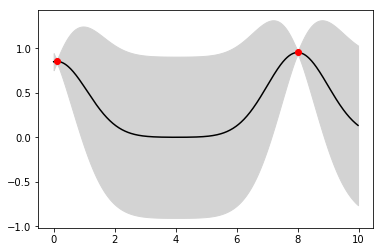

Initial Learning rates: [ 0.1  8. ]
Accuracy: [0.85659999, 0.9562]


In [11]:

sess = tf.InteractiveSession()
h_dim = 100 # Fixed number of hidden dimensions
n = 500 # Number of point in the grid.
xn = np.arange(0,10,10/n)

l_rates = np.array([0.1,8]) # Initial learning rates
f = [nn_train(l, h_dim) for l in tqdm(l_rates)] #Accuracy

noise = 1;length =1; m=0
m, noise, length, sf = opt_hyparams(l_rates,f)
E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
data = data_posterior(xn, E, cov)

#This plot shows the mean and variance with two initial observations:
plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)

Now we perform 5 interations. The figure below exhibits the learning rates selected by the algorithm with their corresponding accuracies. Additionally it shows the new mean and 1 standard deviation around the mean. 

  0%|          | 0/5 [00:00<?, ?it/s]

0: accuracy:0.09 loss: 2.32158 (lr:7.14)
0: ********* epoch 1 ********* test accuracy:0.1439 test loss: 2.30521
20: accuracy:0.49 loss: 1.96123 (lr:7.14)
40: accuracy:0.41 loss: 2.05422 (lr:7.14)
60: accuracy:0.45 loss: 2.01006 (lr:7.14)
80: accuracy:0.71 loss: 1.7428 (lr:7.14)
100: accuracy:0.64 loss: 1.81776 (lr:7.14)
100: ********* epoch 1 ********* test accuracy:0.6998 test loss: 1.7603
120: accuracy:0.78 loss: 1.67732 (lr:7.14)
140: accuracy:0.79 loss: 1.6713 (lr:7.14)
160: accuracy:0.78 loss: 1.66951 (lr:7.14)
180: accuracy:0.78 loss: 1.67632 (lr:7.14)
200: accuracy:0.86 loss: 1.61104 (lr:7.14)
200: ********* epoch 1 ********* test accuracy:0.8282 test loss: 1.6319
220: accuracy:0.86 loss: 1.60522 (lr:7.14)
240: accuracy:0.68 loss: 1.77521 (lr:7.14)
260: accuracy:0.8 loss: 1.65928 (lr:7.14)
280: accuracy:0.86 loss: 1.60296 (lr:7.14)
300: accuracy:0.82 loss: 1.63672 (lr:7.14)
300: ********* epoch 1 ********* test accuracy:0.8204 test loss: 1.63954
320: accuracy:0.77 loss: 1.69114 

2840: accuracy:0.81 loss: 1.65053 (lr:7.14)
2860: accuracy:0.87 loss: 1.58971 (lr:7.14)
2880: accuracy:0.83 loss: 1.62545 (lr:7.14)
2900: accuracy:0.91 loss: 1.55078 (lr:7.14)
2900: ********* epoch 5 ********* test accuracy:0.862 test loss: 1.59854
2920: accuracy:0.86 loss: 1.60058 (lr:7.14)
2940: accuracy:0.91 loss: 1.55208 (lr:7.14)
2960: accuracy:0.81 loss: 1.65093 (lr:7.14)
2980: accuracy:0.86 loss: 1.60095 (lr:7.14)
3000: accuracy:0.82 loss: 1.64089 (lr:7.14)
3000: ********* epoch 6 ********* test accuracy:0.8716 test loss: 1.58926
3020: accuracy:0.84 loss: 1.62276 (lr:7.14)
3040: accuracy:0.87 loss: 1.59101 (lr:7.14)
3060: accuracy:0.87 loss: 1.58795 (lr:7.14)
3080: accuracy:0.87 loss: 1.59475 (lr:7.14)
3100: accuracy:0.86 loss: 1.59799 (lr:7.14)
3100: ********* epoch 6 ********* test accuracy:0.8661 test loss: 1.59433
3120: accuracy:0.88 loss: 1.57796 (lr:7.14)
3140: accuracy:0.86 loss: 1.59655 (lr:7.14)
3160: accuracy:0.93 loss: 1.53099 (lr:7.14)
3180: accuracy:0.89 loss: 1.570

5640: accuracy:0.98 loss: 1.4836 (lr:7.14)
5660: accuracy:0.99 loss: 1.47253 (lr:7.14)
5680: accuracy:0.93 loss: 1.53467 (lr:7.14)
5700: accuracy:0.96 loss: 1.50146 (lr:7.14)
5700: ********* epoch 10 ********* test accuracy:0.9483 test loss: 1.51244
5720: accuracy:0.98 loss: 1.48698 (lr:7.14)
5740: accuracy:0.93 loss: 1.52621 (lr:7.14)
5760: accuracy:0.97 loss: 1.49102 (lr:7.14)
5780: accuracy:1.0 loss: 1.46134 (lr:7.14)
5800: accuracy:0.94 loss: 1.52047 (lr:7.14)
5800: ********* epoch 10 ********* test accuracy:0.942 test loss: 1.51864
5820: accuracy:0.97 loss: 1.49116 (lr:7.14)
5840: accuracy:0.93 loss: 1.53142 (lr:7.14)
5860: accuracy:0.97 loss: 1.49115 (lr:7.14)
5880: accuracy:0.92 loss: 1.54942 (lr:7.14)
5900: accuracy:0.97 loss: 1.49529 (lr:7.14)
5900: ********* epoch 10 ********* test accuracy:0.9564 test loss: 1.50476
5920: accuracy:0.98 loss: 1.48116 (lr:7.14)
5940: accuracy:0.98 loss: 1.48181 (lr:7.14)
5960: accuracy:0.96 loss: 1.50117 (lr:7.14)
5980: accuracy:0.98 loss: 1.48

8440: accuracy:0.97 loss: 1.49115 (lr:7.14)
8460: accuracy:0.97 loss: 1.49156 (lr:7.14)
8480: accuracy:0.97 loss: 1.48948 (lr:7.14)
8500: accuracy:0.95 loss: 1.51428 (lr:7.14)
8500: ********* epoch 15 ********* test accuracy:0.9529 test loss: 1.50804
8520: accuracy:0.97 loss: 1.48876 (lr:7.14)
8540: accuracy:0.96 loss: 1.50115 (lr:7.14)
8560: accuracy:0.97 loss: 1.49082 (lr:7.14)
8580: accuracy:0.93 loss: 1.53115 (lr:7.14)
8600: accuracy:0.94 loss: 1.52535 (lr:7.14)
8600: ********* epoch 15 ********* test accuracy:0.9561 test loss: 1.50473
8620: accuracy:0.97 loss: 1.48879 (lr:7.14)
8640: accuracy:0.97 loss: 1.48997 (lr:7.14)
8660: accuracy:0.98 loss: 1.48115 (lr:7.14)
8680: accuracy:0.92 loss: 1.53703 (lr:7.14)
8700: accuracy:0.98 loss: 1.48112 (lr:7.14)
8700: ********* epoch 15 ********* test accuracy:0.9607 test loss: 1.50024
8720: accuracy:0.98 loss: 1.48116 (lr:7.14)
8740: accuracy:0.97 loss: 1.49115 (lr:7.14)
8760: accuracy:0.99 loss: 1.47116 (lr:7.14)
8780: accuracy:0.97 loss: 1

 20%|██        | 1/5 [00:42<02:49, 42.27s/it]

0: accuracy:0.09 loss: 2.30653 (lr:1.08)
0: ********* epoch 1 ********* test accuracy:0.1047 test loss: 2.3068
20: accuracy:0.61 loss: 1.89505 (lr:1.08)
40: accuracy:0.58 loss: 1.90434 (lr:1.08)
60: accuracy:0.69 loss: 1.78426 (lr:1.08)
80: accuracy:0.81 loss: 1.68594 (lr:1.08)
100: accuracy:0.74 loss: 1.7208 (lr:1.08)
100: ********* epoch 1 ********* test accuracy:0.743 test loss: 1.72914
120: accuracy:0.81 loss: 1.66282 (lr:1.08)
140: accuracy:0.79 loss: 1.67748 (lr:1.08)
160: accuracy:0.8 loss: 1.6725 (lr:1.08)
180: accuracy:0.87 loss: 1.59834 (lr:1.08)
200: accuracy:0.85 loss: 1.62668 (lr:1.08)
200: ********* epoch 1 ********* test accuracy:0.8335 test loss: 1.64083
220: accuracy:0.86 loss: 1.6427 (lr:1.08)
240: accuracy:0.74 loss: 1.72282 (lr:1.08)
260: accuracy:0.89 loss: 1.58316 (lr:1.08)
280: accuracy:0.9 loss: 1.5747 (lr:1.08)
300: accuracy:0.92 loss: 1.53829 (lr:1.08)
300: ********* epoch 1 ********* test accuracy:0.9029 test loss: 1.57126
320: accuracy:0.96 loss: 1.52436 (lr

2840: accuracy:0.95 loss: 1.5144 (lr:1.08)
2860: accuracy:0.98 loss: 1.4834 (lr:1.08)
2880: accuracy:0.99 loss: 1.47722 (lr:1.08)
2900: accuracy:0.96 loss: 1.50824 (lr:1.08)
2900: ********* epoch 5 ********* test accuracy:0.9601 test loss: 1.50362
2920: accuracy:0.98 loss: 1.48819 (lr:1.08)
2940: accuracy:0.96 loss: 1.48968 (lr:1.08)
2960: accuracy:0.96 loss: 1.51394 (lr:1.08)
2980: accuracy:0.96 loss: 1.5146 (lr:1.08)
3000: accuracy:0.96 loss: 1.49378 (lr:1.08)
3000: ********* epoch 6 ********* test accuracy:0.9633 test loss: 1.50117
3020: accuracy:0.99 loss: 1.47188 (lr:1.08)
3040: accuracy:0.96 loss: 1.50564 (lr:1.08)
3060: accuracy:0.95 loss: 1.51303 (lr:1.08)
3080: accuracy:0.97 loss: 1.50077 (lr:1.08)
3100: accuracy:0.98 loss: 1.48804 (lr:1.08)
3100: ********* epoch 6 ********* test accuracy:0.9628 test loss: 1.50115
3120: accuracy:0.91 loss: 1.55909 (lr:1.08)
3140: accuracy:0.99 loss: 1.47266 (lr:1.08)
3160: accuracy:0.98 loss: 1.48357 (lr:1.08)
3180: accuracy:0.93 loss: 1.52681

5700: accuracy:1.0 loss: 1.46652 (lr:1.08)
5700: ********* epoch 10 ********* test accuracy:0.9718 test loss: 1.49228
5720: accuracy:0.98 loss: 1.47744 (lr:1.08)
5740: accuracy:0.99 loss: 1.47441 (lr:1.08)
5760: accuracy:0.94 loss: 1.51416 (lr:1.08)
5780: accuracy:1.0 loss: 1.47033 (lr:1.08)
5800: accuracy:0.99 loss: 1.471 (lr:1.08)
5800: ********* epoch 10 ********* test accuracy:0.9724 test loss: 1.49095
5820: accuracy:0.97 loss: 1.4882 (lr:1.08)
5840: accuracy:0.97 loss: 1.49982 (lr:1.08)
5860: accuracy:0.99 loss: 1.47969 (lr:1.08)
5880: accuracy:0.99 loss: 1.47196 (lr:1.08)
5900: accuracy:0.95 loss: 1.51385 (lr:1.08)
5900: ********* epoch 10 ********* test accuracy:0.9725 test loss: 1.4905
5920: accuracy:0.98 loss: 1.48201 (lr:1.08)
5940: accuracy:0.96 loss: 1.5104 (lr:1.08)
5960: accuracy:0.98 loss: 1.48469 (lr:1.08)
5980: accuracy:0.99 loss: 1.47442 (lr:1.08)
6000: accuracy:0.96 loss: 1.51102 (lr:1.08)
6000: ********* epoch 11 ********* test accuracy:0.9732 test loss: 1.49034
602

8500: accuracy:0.98 loss: 1.48567 (lr:1.08)
8500: ********* epoch 15 ********* test accuracy:0.9771 test loss: 1.48606
8520: accuracy:0.99 loss: 1.47381 (lr:1.08)
8540: accuracy:1.0 loss: 1.46565 (lr:1.08)
8560: accuracy:0.97 loss: 1.49336 (lr:1.08)
8580: accuracy:0.96 loss: 1.49789 (lr:1.08)
8600: accuracy:0.99 loss: 1.4735 (lr:1.08)
8600: ********* epoch 15 ********* test accuracy:0.9761 test loss: 1.48692
8620: accuracy:0.99 loss: 1.47262 (lr:1.08)
8640: accuracy:0.99 loss: 1.46942 (lr:1.08)
8660: accuracy:0.99 loss: 1.47328 (lr:1.08)
8680: accuracy:1.0 loss: 1.46271 (lr:1.08)
8700: accuracy:0.99 loss: 1.47527 (lr:1.08)
8700: ********* epoch 15 ********* test accuracy:0.975 test loss: 1.48729
8720: accuracy:0.95 loss: 1.51481 (lr:1.08)
8740: accuracy:0.99 loss: 1.47279 (lr:1.08)
8760: accuracy:1.0 loss: 1.46229 (lr:1.08)
8780: accuracy:0.99 loss: 1.47431 (lr:1.08)
8800: accuracy:0.99 loss: 1.47079 (lr:1.08)
8800: ********* epoch 15 ********* test accuracy:0.9742 test loss: 1.488
882

 40%|████      | 2/5 [01:14<01:57, 39.12s/it]

0: accuracy:0.11 loss: 2.3093 (lr:9.98)
0: ********* epoch 1 ********* test accuracy:0.0996 test loss: 2.30702
20: accuracy:0.15 loss: 2.296 (lr:9.98)
40: accuracy:0.4 loss: 2.061 (lr:9.98)
60: accuracy:0.56 loss: 1.88525 (lr:9.98)
80: accuracy:0.58 loss: 1.86193 (lr:9.98)
100: accuracy:0.75 loss: 1.71753 (lr:9.98)
100: ********* epoch 1 ********* test accuracy:0.6944 test loss: 1.76775
120: accuracy:0.74 loss: 1.72046 (lr:9.98)
140: accuracy:0.8 loss: 1.66472 (lr:9.98)
160: accuracy:0.8 loss: 1.66468 (lr:9.98)
180: accuracy:0.82 loss: 1.6435 (lr:9.98)
200: accuracy:0.81 loss: 1.63755 (lr:9.98)
200: ********* epoch 1 ********* test accuracy:0.8119 test loss: 1.64892
220: accuracy:0.84 loss: 1.61594 (lr:9.98)
240: accuracy:0.75 loss: 1.70479 (lr:9.98)
260: accuracy:0.7 loss: 1.76216 (lr:9.98)
280: accuracy:0.81 loss: 1.64997 (lr:9.98)
300: accuracy:0.83 loss: 1.64385 (lr:9.98)
300: ********* epoch 1 ********* test accuracy:0.8232 test loss: 1.63788
320: accuracy:0.88 loss: 1.58074 (lr:9

2840: accuracy:0.71 loss: 1.75066 (lr:9.98)
2860: accuracy:0.83 loss: 1.63097 (lr:9.98)
2880: accuracy:0.89 loss: 1.57095 (lr:9.98)
2900: accuracy:0.82 loss: 1.64079 (lr:9.98)
2900: ********* epoch 5 ********* test accuracy:0.8503 test loss: 1.61044
2920: accuracy:0.84 loss: 1.62086 (lr:9.98)
2940: accuracy:0.85 loss: 1.6111 (lr:9.98)
2960: accuracy:0.85 loss: 1.61026 (lr:9.98)
2980: accuracy:0.88 loss: 1.58065 (lr:9.98)
3000: accuracy:0.87 loss: 1.59106 (lr:9.98)
3000: ********* epoch 6 ********* test accuracy:0.8443 test loss: 1.61662
3020: accuracy:0.84 loss: 1.61928 (lr:9.98)
3040: accuracy:0.88 loss: 1.58114 (lr:9.98)
3060: accuracy:0.82 loss: 1.64029 (lr:9.98)
3080: accuracy:0.83 loss: 1.63448 (lr:9.98)
3100: accuracy:0.86 loss: 1.60115 (lr:9.98)
3100: ********* epoch 6 ********* test accuracy:0.855 test loss: 1.60598
3120: accuracy:0.9 loss: 1.56059 (lr:9.98)
3140: accuracy:0.88 loss: 1.58077 (lr:9.98)
3160: accuracy:0.86 loss: 1.6 (lr:9.98)
3180: accuracy:0.9 loss: 1.56114 (lr:

5700: ********* epoch 10 ********* test accuracy:0.8562 test loss: 1.60501
5720: accuracy:0.85 loss: 1.61254 (lr:9.98)
5740: accuracy:0.88 loss: 1.58116 (lr:9.98)
5760: accuracy:0.79 loss: 1.67256 (lr:9.98)
5780: accuracy:0.81 loss: 1.65111 (lr:9.98)
5800: accuracy:0.84 loss: 1.62115 (lr:9.98)
5800: ********* epoch 10 ********* test accuracy:0.8556 test loss: 1.60548
5820: accuracy:0.9 loss: 1.56114 (lr:9.98)
5840: accuracy:0.83 loss: 1.63083 (lr:9.98)
5860: accuracy:0.93 loss: 1.53153 (lr:9.98)
5880: accuracy:0.86 loss: 1.60512 (lr:9.98)
5900: accuracy:0.78 loss: 1.68112 (lr:9.98)
5900: ********* epoch 10 ********* test accuracy:0.8536 test loss: 1.60745
5920: accuracy:0.84 loss: 1.62115 (lr:9.98)
5940: accuracy:0.92 loss: 1.53421 (lr:9.98)
5960: accuracy:0.83 loss: 1.63191 (lr:9.98)
5980: accuracy:0.94 loss: 1.52113 (lr:9.98)
6000: accuracy:0.85 loss: 1.611 (lr:9.98)
6000: ********* epoch 11 ********* test accuracy:0.8586 test loss: 1.60251
6020: accuracy:0.85 loss: 1.61115 (lr:9.98)

8520: accuracy:0.87 loss: 1.59114 (lr:9.98)
8540: accuracy:0.79 loss: 1.67099 (lr:9.98)
8560: accuracy:0.82 loss: 1.63639 (lr:9.98)
8580: accuracy:0.88 loss: 1.58115 (lr:9.98)
8600: accuracy:0.8 loss: 1.65811 (lr:9.98)
8600: ********* epoch 15 ********* test accuracy:0.8628 test loss: 1.59827
8620: accuracy:0.8 loss: 1.6637 (lr:9.98)
8640: accuracy:0.84 loss: 1.62114 (lr:9.98)
8660: accuracy:0.86 loss: 1.60112 (lr:9.98)
8680: accuracy:0.9 loss: 1.56115 (lr:9.98)
8700: accuracy:0.84 loss: 1.62104 (lr:9.98)
8700: ********* epoch 15 ********* test accuracy:0.8631 test loss: 1.59789
8720: accuracy:0.82 loss: 1.64072 (lr:9.98)
8740: accuracy:0.87 loss: 1.59115 (lr:9.98)
8760: accuracy:0.82 loss: 1.64054 (lr:9.98)
8780: accuracy:0.87 loss: 1.59087 (lr:9.98)
8800: accuracy:0.83 loss: 1.63105 (lr:9.98)
8800: ********* epoch 15 ********* test accuracy:0.8496 test loss: 1.61145
8820: accuracy:0.85 loss: 1.61117 (lr:9.98)
8840: accuracy:0.91 loss: 1.55115 (lr:9.98)
8860: accuracy:0.85 loss: 1.611

 60%|██████    | 3/5 [01:49<01:16, 38.16s/it]

0: accuracy:0.13 loss: 2.30451 (lr:3.64)
0: ********* epoch 1 ********* test accuracy:0.1213 test loss: 2.30381
20: accuracy:0.59 loss: 1.90192 (lr:3.64)
40: accuracy:0.77 loss: 1.69442 (lr:3.64)
60: accuracy:0.79 loss: 1.677 (lr:3.64)
80: accuracy:0.78 loss: 1.68605 (lr:3.64)
100: accuracy:0.81 loss: 1.65083 (lr:3.64)
100: ********* epoch 1 ********* test accuracy:0.8439 test loss: 1.62182
120: accuracy:0.79 loss: 1.67402 (lr:3.64)
140: accuracy:0.8 loss: 1.65311 (lr:3.64)
160: accuracy:0.88 loss: 1.58989 (lr:3.64)
180: accuracy:0.91 loss: 1.55106 (lr:3.64)
200: accuracy:0.86 loss: 1.59797 (lr:3.64)
200: ********* epoch 1 ********* test accuracy:0.913 test loss: 1.55123
220: accuracy:0.92 loss: 1.54938 (lr:3.64)
240: accuracy:0.89 loss: 1.58324 (lr:3.64)
260: accuracy:0.93 loss: 1.53058 (lr:3.64)
280: accuracy:0.94 loss: 1.53125 (lr:3.64)
300: accuracy:0.9 loss: 1.55957 (lr:3.64)
300: ********* epoch 1 ********* test accuracy:0.9269 test loss: 1.53633
320: accuracy:0.92 loss: 1.5441 (

2860: accuracy:0.98 loss: 1.47783 (lr:3.64)
2880: accuracy:0.97 loss: 1.49121 (lr:3.64)
2900: accuracy:0.99 loss: 1.46973 (lr:3.64)
2900: ********* epoch 5 ********* test accuracy:0.9614 test loss: 1.50048
2920: accuracy:1.0 loss: 1.46455 (lr:3.64)
2940: accuracy:0.99 loss: 1.47174 (lr:3.64)
2960: accuracy:0.97 loss: 1.49073 (lr:3.64)
2980: accuracy:0.98 loss: 1.48154 (lr:3.64)
3000: accuracy:1.0 loss: 1.46396 (lr:3.64)
3000: ********* epoch 6 ********* test accuracy:0.9659 test loss: 1.49584
3020: accuracy:0.97 loss: 1.49234 (lr:3.64)
3040: accuracy:0.96 loss: 1.50694 (lr:3.64)
3060: accuracy:0.94 loss: 1.51526 (lr:3.64)
3080: accuracy:0.96 loss: 1.49335 (lr:3.64)
3100: accuracy:0.99 loss: 1.473 (lr:3.64)
3100: ********* epoch 6 ********* test accuracy:0.9674 test loss: 1.49443
3120: accuracy:0.96 loss: 1.50433 (lr:3.64)
3140: accuracy:0.97 loss: 1.48856 (lr:3.64)
3160: accuracy:0.94 loss: 1.51508 (lr:3.64)
3180: accuracy:0.97 loss: 1.48972 (lr:3.64)
3200: accuracy:1.0 loss: 1.46196 (

5680: accuracy:0.98 loss: 1.48191 (lr:3.64)
5700: accuracy:0.99 loss: 1.47238 (lr:3.64)
5700: ********* epoch 10 ********* test accuracy:0.9728 test loss: 1.48847
5720: accuracy:0.98 loss: 1.4717 (lr:3.64)
5740: accuracy:1.0 loss: 1.4613 (lr:3.64)
5760: accuracy:1.0 loss: 1.46512 (lr:3.64)
5780: accuracy:0.99 loss: 1.47333 (lr:3.64)
5800: accuracy:0.97 loss: 1.49445 (lr:3.64)
5800: ********* epoch 10 ********* test accuracy:0.9705 test loss: 1.49061
5820: accuracy:0.97 loss: 1.49004 (lr:3.64)
5840: accuracy:0.99 loss: 1.47588 (lr:3.64)
5860: accuracy:1.0 loss: 1.46337 (lr:3.64)
5880: accuracy:1.0 loss: 1.46139 (lr:3.64)
5900: accuracy:0.96 loss: 1.49872 (lr:3.64)
5900: ********* epoch 10 ********* test accuracy:0.9717 test loss: 1.48963
5920: accuracy:0.97 loss: 1.49056 (lr:3.64)
5940: accuracy:0.99 loss: 1.47131 (lr:3.64)
5960: accuracy:0.97 loss: 1.49061 (lr:3.64)
5980: accuracy:0.97 loss: 1.48961 (lr:3.64)
6000: accuracy:0.99 loss: 1.47081 (lr:3.64)
6000: ********* epoch 11 ********

8480: accuracy:0.99 loss: 1.476 (lr:3.64)
8500: accuracy:0.99 loss: 1.47254 (lr:3.64)
8500: ********* epoch 15 ********* test accuracy:0.9739 test loss: 1.48688
8520: accuracy:0.99 loss: 1.47117 (lr:3.64)
8540: accuracy:1.0 loss: 1.46163 (lr:3.64)
8560: accuracy:0.99 loss: 1.46649 (lr:3.64)
8580: accuracy:1.0 loss: 1.46159 (lr:3.64)
8600: accuracy:0.98 loss: 1.47877 (lr:3.64)
8600: ********* epoch 15 ********* test accuracy:0.9769 test loss: 1.48423
8620: accuracy:0.99 loss: 1.4713 (lr:3.64)
8640: accuracy:0.99 loss: 1.47537 (lr:3.64)
8660: accuracy:0.98 loss: 1.47545 (lr:3.64)
8680: accuracy:0.98 loss: 1.48248 (lr:3.64)
8700: accuracy:0.97 loss: 1.49602 (lr:3.64)
8700: ********* epoch 15 ********* test accuracy:0.9754 test loss: 1.48632
8720: accuracy:0.98 loss: 1.47558 (lr:3.64)
8740: accuracy:1.0 loss: 1.46363 (lr:3.64)
8760: accuracy:0.98 loss: 1.48235 (lr:3.64)
8780: accuracy:0.95 loss: 1.50537 (lr:3.64)
8800: accuracy:1.0 loss: 1.46249 (lr:3.64)
8800: ********* epoch 15 *********

 80%|████████  | 4/5 [02:29<00:38, 38.62s/it]

0: accuracy:0.11 loss: 2.3 (lr:2.58)
0: ********* epoch 1 ********* test accuracy:0.1022 test loss: 2.29952
20: accuracy:0.58 loss: 1.88175 (lr:2.58)
40: accuracy:0.71 loss: 1.74759 (lr:2.58)
60: accuracy:0.84 loss: 1.63895 (lr:2.58)
80: accuracy:0.79 loss: 1.66328 (lr:2.58)
100: accuracy:0.81 loss: 1.66642 (lr:2.58)
100: ********* epoch 1 ********* test accuracy:0.8313 test loss: 1.63535
120: accuracy:0.78 loss: 1.67404 (lr:2.58)
140: accuracy:0.86 loss: 1.606 (lr:2.58)
160: accuracy:0.9 loss: 1.56981 (lr:2.58)
180: accuracy:0.83 loss: 1.638 (lr:2.58)
200: accuracy:0.89 loss: 1.57386 (lr:2.58)
200: ********* epoch 1 ********* test accuracy:0.8672 test loss: 1.60333
220: accuracy:0.85 loss: 1.60492 (lr:2.58)
240: accuracy:0.84 loss: 1.61974 (lr:2.58)
260: accuracy:0.84 loss: 1.64408 (lr:2.58)
280: accuracy:0.88 loss: 1.58356 (lr:2.58)
300: accuracy:0.85 loss: 1.61788 (lr:2.58)
300: ********* epoch 1 ********* test accuracy:0.8712 test loss: 1.59357
320: accuracy:0.94 loss: 1.53032 (lr:

2900: accuracy:0.97 loss: 1.49272 (lr:2.58)
2900: ********* epoch 5 ********* test accuracy:0.9683 test loss: 1.49413
2920: accuracy:0.96 loss: 1.5003 (lr:2.58)
2940: accuracy:0.99 loss: 1.47135 (lr:2.58)
2960: accuracy:0.95 loss: 1.51582 (lr:2.58)
2980: accuracy:0.97 loss: 1.49692 (lr:2.58)
3000: accuracy:0.97 loss: 1.49227 (lr:2.58)
3000: ********* epoch 6 ********* test accuracy:0.9576 test loss: 1.50513
3020: accuracy:0.99 loss: 1.47296 (lr:2.58)
3040: accuracy:0.98 loss: 1.48104 (lr:2.58)
3060: accuracy:0.97 loss: 1.49416 (lr:2.58)
3080: accuracy:0.97 loss: 1.49645 (lr:2.58)
3100: accuracy:0.93 loss: 1.53044 (lr:2.58)
3100: ********* epoch 6 ********* test accuracy:0.9667 test loss: 1.49564
3120: accuracy:0.99 loss: 1.4761 (lr:2.58)
3140: accuracy:0.96 loss: 1.49888 (lr:2.58)
3160: accuracy:0.98 loss: 1.48329 (lr:2.58)
3180: accuracy:0.95 loss: 1.50582 (lr:2.58)
3200: accuracy:0.97 loss: 1.49229 (lr:2.58)
3200: ********* epoch 6 ********* test accuracy:0.9701 test loss: 1.49158
32

5720: accuracy:0.97 loss: 1.48847 (lr:2.58)
5740: accuracy:1.0 loss: 1.46143 (lr:2.58)
5760: accuracy:0.98 loss: 1.48122 (lr:2.58)
5780: accuracy:0.99 loss: 1.4709 (lr:2.58)
5800: accuracy:0.97 loss: 1.49154 (lr:2.58)
5800: ********* epoch 10 ********* test accuracy:0.9728 test loss: 1.48874
5820: accuracy:0.98 loss: 1.48073 (lr:2.58)
5840: accuracy:0.98 loss: 1.48501 (lr:2.58)
5860: accuracy:0.96 loss: 1.49939 (lr:2.58)
5880: accuracy:0.98 loss: 1.48021 (lr:2.58)
5900: accuracy:0.96 loss: 1.49378 (lr:2.58)
5900: ********* epoch 10 ********* test accuracy:0.9746 test loss: 1.48711
5920: accuracy:0.98 loss: 1.48515 (lr:2.58)
5940: accuracy:0.98 loss: 1.48203 (lr:2.58)
5960: accuracy:0.94 loss: 1.51546 (lr:2.58)
5980: accuracy:0.99 loss: 1.46993 (lr:2.58)
6000: accuracy:0.99 loss: 1.47251 (lr:2.58)
6000: ********* epoch 11 ********* test accuracy:0.9752 test loss: 1.48633
6020: accuracy:0.99 loss: 1.47288 (lr:2.58)
6040: accuracy:1.0 loss: 1.46493 (lr:2.58)
6060: accuracy:1.0 loss: 1.464

8540: accuracy:1.0 loss: 1.46209 (lr:2.58)
8560: accuracy:0.98 loss: 1.47226 (lr:2.58)
8580: accuracy:1.0 loss: 1.46185 (lr:2.58)
8600: accuracy:0.99 loss: 1.47132 (lr:2.58)
8600: ********* epoch 15 ********* test accuracy:0.9782 test loss: 1.48373
8620: accuracy:1.0 loss: 1.46192 (lr:2.58)
8640: accuracy:0.99 loss: 1.47459 (lr:2.58)
8660: accuracy:0.99 loss: 1.47131 (lr:2.58)
8680: accuracy:0.98 loss: 1.48155 (lr:2.58)
8700: accuracy:0.98 loss: 1.48103 (lr:2.58)
8700: ********* epoch 15 ********* test accuracy:0.9762 test loss: 1.48548
8720: accuracy:0.98 loss: 1.48114 (lr:2.58)
8740: accuracy:1.0 loss: 1.46241 (lr:2.58)
8760: accuracy:0.99 loss: 1.47184 (lr:2.58)
8780: accuracy:1.0 loss: 1.463 (lr:2.58)
8800: accuracy:1.0 loss: 1.46415 (lr:2.58)
8800: ********* epoch 15 ********* test accuracy:0.9769 test loss: 1.48488
8820: accuracy:0.99 loss: 1.4715 (lr:2.58)
8840: accuracy:0.98 loss: 1.48135 (lr:2.58)
8860: accuracy:1.0 loss: 1.46144 (lr:2.58)
8880: accuracy:0.98 loss: 1.48439 (lr

100%|██████████| 5/5 [03:12<00:00, 39.79s/it]


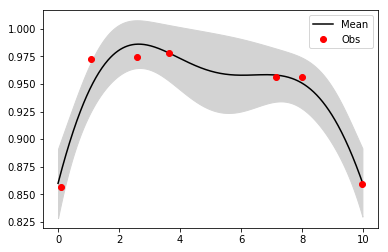

Initial Learning rates: [ 0.1   8.    7.14  1.08  9.98  3.64  2.58]
Accuracy: [ 0.85659999  0.9562      0.95639998  0.97289997  0.85970002  0.97790003
  0.97490001]


In [13]:
#If sf is used, we have to use opt_hyparams_noise, otherwise use opt_hyparams. 
n_iter = 5

for i in tqdm(range(n_iter)):
    next_candidate = acquisition_fun(l_rates, f, xn, np.array(data['Mean']), np.array(data['StdDev']))
    l_rates = np.append(l_rates,next_candidate)
    f = np.append(f,nn_train(next_candidate, h_dim))
    E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
    data = data_posterior(xn, E, cov)

    try:
        m, noise, length, sf = opt_hyparams(l_rates,f)
    except ValueError:
        m, noise, length, sf = m, noise, length, sf


plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')

plt.legend()
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)


From the plot, we observe how the algorithm explores the domain of the hyperparameter, searching for the most appropiate learning rate. In this examples the initial learning rates are 0.1 and 8. After 5 interations the algorithm recomends a learning rate that allows to increase the accuracy from the region in [0.9, 0.92] to [0.93, 0.95].

## Accuracy evaluation with decaying learning rate - w/o bayesian optimisation

In [12]:
sess = tf.InteractiveSession()
%time nn_train_var(min_lr=0.1, max_lr=10, h_dim=100, minibatch = 100)

0: accuracy:0.11 loss: 2.30224 (lr:10.0)
0: ********* epoch 1 ********* test accuracy:0.1095 test loss: 2.29958
20: accuracy:0.31 loss: 2.12496 (lr:9.901493354116765)
40: accuracy:0.41 loss: 2.05033 (lr:9.803966865736877)
60: accuracy:0.73 loss: 1.7259 (lr:9.70741078213023)
80: accuracy:0.69 loss: 1.76293 (lr:9.611815447607999)
100: accuracy:0.74 loss: 1.71246 (lr:9.517171302557069)
100: ********* epoch 1 ********* test accuracy:0.755 test loss: 1.70362
120: accuracy:0.65 loss: 1.81477 (lr:9.423468882484062)
140: accuracy:0.9 loss: 1.56727 (lr:9.330698817068887)
160: accuracy:0.78 loss: 1.6941 (lr:9.238851829227693)
180: accuracy:0.83 loss: 1.63882 (lr:9.14791873418516)
200: accuracy:0.89 loss: 1.56942 (lr:9.057890438555999)
200: ********* epoch 1 ********* test accuracy:0.899 test loss: 1.5613
220: accuracy:0.9 loss: 1.56653 (lr:8.96875793943563)
240: accuracy:0.85 loss: 1.60431 (lr:8.88051232349986)
260: accuracy:0.82 loss: 1.63697 (lr:8.793144766113556)
280: accuracy:0.87 loss: 1.58

2300: ********* epoch 4 ********* test accuracy:0.9544 test loss: 1.50673
2320: accuracy:0.97 loss: 1.49034 (lr:3.2035131907377927)
2340: accuracy:0.94 loss: 1.51651 (lr:3.172632718528302)
2360: accuracy:0.93 loss: 1.52875 (lr:3.1420595121511994)
2380: accuracy:0.94 loss: 1.52137 (lr:3.111790514260371)
2400: accuracy:0.99 loss: 1.46876 (lr:3.0818226979308014)
2400: ********* epoch 5 ********* test accuracy:0.9583 test loss: 1.50223
2420: accuracy:0.98 loss: 1.48381 (lr:3.0521530663558853)
2440: accuracy:0.97 loss: 1.49035 (lr:3.022778652547741)
2460: accuracy:0.97 loss: 1.49107 (lr:2.9936965190405083)
2480: accuracy:0.97 loss: 1.49158 (lr:2.964903757596601)
2500: accuracy:0.98 loss: 1.48202 (lr:2.936397488915882)
2500: ********* epoch 5 ********* test accuracy:0.9542 test loss: 1.5068
2520: accuracy:0.92 loss: 1.54182 (lr:2.9081748623477273)
2540: accuracy:0.96 loss: 1.50145 (lr:2.88023305560596)
2560: accuracy:0.94 loss: 1.52123 (lr:2.8525692744866222)
2580: accuracy:0.96 loss: 1.5011

4600: ********* epoch 8 ********* test accuracy:0.9663 test loss: 1.49562
4620: accuracy:0.93 loss: 1.52773 (lr:1.082686390440492)
4640: accuracy:0.99 loss: 1.47103 (lr:1.0729084974831793)
4660: accuracy:0.96 loss: 1.50053 (lr:1.0632278961863744)
4680: accuracy:0.98 loss: 1.47918 (lr:1.0536436184818812)
4700: accuracy:0.96 loss: 1.49616 (lr:1.0441547059339413)
4700: ********* epoch 8 ********* test accuracy:0.9636 test loss: 1.49711
4720: accuracy:0.97 loss: 1.49147 (lr:1.0347602096433932)
4740: accuracy:0.99 loss: 1.47083 (lr:1.025459190152779)
4760: accuracy:0.98 loss: 1.47738 (lr:1.0162507173523987)
4780: accuracy:0.97 loss: 1.49102 (lr:1.0071338703872978)
4800: accuracy:0.98 loss: 1.48229 (lr:0.9981077375651839)
4800: ********* epoch 9 ********* test accuracy:0.9627 test loss: 1.49805
4820: accuracy:0.97 loss: 1.49142 (lr:0.9891714162652515)
4840: accuracy:0.97 loss: 1.49427 (lr:0.9803240128479248)
4860: accuracy:0.97 loss: 1.49487 (lr:0.9715646425654882)
4880: accuracy:0.95 loss: 

6860: accuracy:0.97 loss: 1.49252 (lr:0.42063071365177973)
6880: accuracy:0.99 loss: 1.4718 (lr:0.4174403847458217)
6900: accuracy:0.97 loss: 1.4912 (lr:0.41428180014287264)
6900: ********* epoch 12 ********* test accuracy:0.9664 test loss: 1.49477
6920: accuracy:0.98 loss: 1.47862 (lr:0.4111546439818403)
6940: accuracy:0.94 loss: 1.52104 (lr:0.4080586035445025)
6960: accuracy:0.99 loss: 1.47118 (lr:0.4049933692242357)
6980: accuracy:0.99 loss: 1.47211 (lr:0.4019586344950531)
7000: accuracy:0.98 loss: 1.48142 (lr:0.3989540958809532)
7000: ********* epoch 12 ********* test accuracy:0.9667 test loss: 1.49448
7020: accuracy:0.97 loss: 1.49181 (lr:0.3959794529255706)
7040: accuracy:1.0 loss: 1.46117 (lr:0.39303440816213076)
7060: accuracy:0.97 loss: 1.49696 (lr:0.3901186670837036)
7080: accuracy:0.96 loss: 1.50272 (lr:0.3872319381137509)
7100: accuracy:0.98 loss: 1.48126 (lr:0.3843739325769704)
7100: ********* epoch 12 ********* test accuracy:0.9662 test loss: 1.49484
7120: accuracy:0.98 l

9120: accuracy:0.98 loss: 1.48136 (lr:0.20357438353992535)
9140: accuracy:0.98 loss: 1.48087 (lr:0.2025438012043756)
9160: accuracy:0.98 loss: 1.4813 (lr:0.20152347333439985)
9180: accuracy:0.97 loss: 1.49147 (lr:0.20051329789636066)
9200: accuracy:0.98 loss: 1.48159 (lr:0.1995131738718725)
9200: ********* epoch 16 ********* test accuracy:0.9675 test loss: 1.4943
9220: accuracy:0.97 loss: 1.49148 (lr:0.19852300124769937)
9240: accuracy:0.96 loss: 1.50148 (lr:0.19754268100575384)
9260: accuracy:0.99 loss: 1.47117 (lr:0.19657211511319475)
9280: accuracy:0.99 loss: 1.47213 (lr:0.19561120651262398)
9300: accuracy:0.99 loss: 1.4705 (lr:0.1946598591123807)
9300: ********* epoch 16 ********* test accuracy:0.9672 test loss: 1.49428
9320: accuracy:0.99 loss: 1.47115 (lr:0.19371797777693223)
9340: accuracy:0.95 loss: 1.506 (lr:0.19278546831736)
9360: accuracy:0.95 loss: 1.51105 (lr:0.19186223748194098)
9380: accuracy:0.94 loss: 1.521 (lr:0.1909481929468222)
9400: accuracy:0.97 loss: 1.49402 (lr:

0.96710002